# Recommendations

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Make plots inline

In [2]:
%matplotlib inline

Load the data

In [3]:
def load():
    from scipy import sparse

    data = np.loadtxt('data/ml-100k/u.data')
    ij = data[:, :2]
    ij -= 1  # original data is in 1-based system
    values = data[:, 2]
    reviews = sparse.csc_matrix((values, ij.T)).astype(float)
    return reviews.toarray()
reviews = load()
U,M = np.where(reviews)

Split the data into training/testing:

In [4]:
def get_train_test(reviews):
    import random
    test_idxs = np.array(random.sample(range(len(U)), len(U)//10))

    train = reviews.copy()
    train[U[test_idxs], M[test_idxs]] = 0

    test = np.zeros_like(reviews)
    test[U[test_idxs], M[test_idxs]] = reviews[U[test_idxs], M[test_idxs]]
    return train, test

train, test = get_train_test(reviews)

For normalization, we make a class that _follows the scikit-learn API_:

In [5]:
class NormalizePositive(object):
    def __init__(self, axis=0):
        self.axis = axis

    def fit(self, features, y=None):
        if self.axis == 1:
            features = features.T
          #  count features that are greater than zero in axis 0:
        binary = (features > 0)

        count0 = binary.sum(axis=0)

         # to avoid division by zero, set zero counts to one:
        count0[count0 == 0] = 1.

         # computing the mean is easy:
        self.mean = features.sum(axis=0)/count0

        # only consider differences where binary is True:
        diff = (features - self.mean) * binary
        diff **= 2
        # regularize the estimate of std by adding 0.1
        self.std = np.sqrt(0.1 + diff.sum(axis=0)/count0)
        return self


    def transform(self, features):
        if self.axis == 1:
            features = features.T
        binary = (features > 0)
        features = features - self.mean
        features /= self.std
        features *= binary
        if self.axis == 1:
            features = features.T
        return features

    def inverse_transform(self, features, copy=True):
        if copy:
            features = features.copy()
        if self.axis == 1:
            features = features.T
        features *= self.std
        features += self.mean
        if self.axis == 1:
            features = features.T
        return features

    def fit_transform(self, features):
        return self.fit(features).transform(features)

We can quickly visualize the matrix to see what our data looks like:

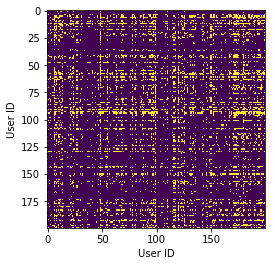

In [6]:
binary = (train > 0)
fig,ax = plt.subplots()
# plot just 200x200 area for space reasons
ax.imshow(binary[:200, :200], interpolation='nearest')
ax.set_xlabel('User ID')
ax.set_ylabel('User ID')
fig.savefig('IMG_REC_01.png', dpi=300)

In [7]:
def predict_positive_nn(otrain, necessary=None):
    from scipy.spatial import distance
    binary = (otrain > 0)
    norm = NormalizePositive(axis=1)
    train = norm.fit_transform(otrain)
    
    # compute all pair-wise distances:
    dists = distance.pdist(binary, 'correlation')
    # Convert to square form, so that `dists[i,j]`
    # contains the distance between `binary[i]` and `binary[j]`:
    dists = distance.squareform(dists)

    neighbors = dists.argsort(axis=1)
    filled = train.copy()
    for u in range(filled.shape[0]):
        # n_u are the neighbors of user
        n_u = neighbors[u, 1:]
        for m in range(filled.shape[1]):
            if necessary is not None and not necessary[u, m]:
                continue
            # This code could be faster using numpy indexing trickery as the
            # cost of readibility (this is left as an exercise to the reader):
            revs = [train[neigh, m]
                    for neigh in n_u
                    if binary[neigh, m]]
            if len(revs):
                n = len(revs)
                n //= 2
                n += 1
                revs = revs[:n]
                filled[u,m] = np.mean(revs)
    # Finally, undo the normalization to get back the final reusl
    return norm.inverse_transform(filled)


Call the `predict_positive_nn` function

In [8]:
predicted = predict_positive_nn(train, test != 0)

We can use the R² metric to evaluate how well we do

In [9]:
from sklearn import metrics
r2 = metrics.r2_score(test[test != 0], predicted[test != 0])
print('R2 score (binary user neighbors): {:.1%}'.format(r2))

R2 score (binary user neighbors): 30.4%


In [10]:
predicted = predict_positive_nn(train.T, (test != 0).T).T
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (binary movie neighbors): {:.1%}'.format(r2))

R2 score (binary movie neighbors): 31.5%


## Regression for recommendations


We can use regression for recommendations as well

In [11]:
def predict_regression(otrain):
    from sklearn.linear_model import ElasticNetCV
    binary = (otrain > 0)
    norm = NormalizePositive(axis=1)
    train = norm.fit_transform(otrain)

    reg = ElasticNetCV(alphas=[
                           0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])
    filled = train.copy()
    # iterate over all users:
    for u in range(train.shape[0]):
        curtrain = np.delete(train, u, axis=0)
        bu = binary[u]
        if np.sum(bu) > 10:
            reg.fit(curtrain[:,bu].T, train[u, bu])
            # Fill the values that were not there already
            filled[u, ~bu] = reg.predict(curtrain[:,~bu].T)
    return norm.inverse_transform(filled)

In [12]:
predicted = predict_regression(train)
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (user regression): {:.1%}'.format(r2))

R2 score (user regression): 28.6%


In [13]:
predicted = predict_regression(train.T).T
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (movie regression): {:.1%}'.format(r2))

R2 score (movie regression): 26.2%


## Combining multiple methods

In [14]:
def predict_stacked(train):
    from sklearn import linear_model
    tr_train,tr_test = get_train_test(train)
    tr_predicted0 = predict_positive_nn(tr_train, tr_test != 0)
    tr_predicted1 = predict_positive_nn(tr_train.T, (tr_test != 0).T).T
    tr_predicted2 = predict_regression(tr_train)
    tr_predicted3 = predict_regression(tr_train.T).T
    stack_tr = np.array([
        tr_predicted0[tr_test > 0],
        tr_predicted1[tr_test > 0],
        tr_predicted2[tr_test > 0],
        tr_predicted3[tr_test > 0],
        ]).T

    lr = linear_model.LinearRegression()
    lr.fit(stack_tr, tr_test[tr_test > 0])

    stack_te = np.array([
        tr_predicted0.ravel(),
        tr_predicted1.ravel(),
        tr_predicted2.ravel(),
        tr_predicted3.ravel(),
        ]).T

    return lr.predict(stack_te).reshape(train.shape)

We can use the same evaluation as before:

In [15]:
predicted = predict_stacked(train)
r2 = metrics.r2_score(test[test > 0], predicted[test > 0])
print('R2 score (stacked prediction): {:.1%}'.format(r2))

R2 score (stacked prediction): 32.0%


# SHOPPING BASKET ANALYSIS
This is the slow version of the code, which will take a long time to complete.

In [16]:
from collections import defaultdict
from itertools import chain

You **must** have downloaded the data before running this analysis. The data is downloaded as a compressed file

In [17]:
import gzip
# file format is a line per transaction
# of the form '12 34 342 5...'
dataset = [[int(tok) for tok in line.strip().split()]
       for line in gzip.open('data/retail.dat.gz')]
dataset = [set(d) for d in dataset]

Count how often each product was purchased:

In [18]:
counts = defaultdict(int)
for elem in chain(*dataset):
    counts[elem] += 1

Print a little histogram:

In [19]:
countsv = np.array(list(counts.values()))
bins = [1, 2, 4, 8, 16, 32, 64, 128, 512]
print(' {0:11} | {1:12}'.format('Nr of baskets', 'Nr of products'))
print('--------------------------------')
for i in range(len(bins)):
    bot = bins[i]
    top = (bins[i + 1] if (i + 1) < len(bins) else 100000000000)
    print('  {0:4} - {1:3}   | {2:12}'.format(
        bot, (top if top < 1000 else ''), np.sum((countsv >= bot) & (countsv < top))))

 Nr of baskets | Nr of products
--------------------------------
     1 -   2   |         2224
     2 -   4   |         2438
     4 -   8   |         2508
     8 -  16   |         2251
    16 -  32   |         2182
    32 -  64   |         1940
    64 - 128   |         1523
   128 - 512   |         1225
   512 -       |          179


In [ ]:
minsupport = 100
valid = set(k for k,v in counts.items() if (v >= minsupport))
dataset = [(valid&d) for d in dataset if len(valid&d)]

baskets = defaultdict(set)

for i, ds in enumerate(dataset):                  
    for ell in ds:
        baskets[ell].add(i)       

In [ ]:
itemsets = [frozenset([v]) for v in valid]
freqsets = []
for i in range(16):
    nextsets = []
    tested = set()
    for it in itemsets:
        for v in valid:
            if v not in it:
                # Create a new candidate set by adding v to it
                c = (it | frozenset([v]))
                # check if we have tested it already
                if c in tested:
                    continue
                tested.add(c)

                candidates = set()
                for elem in c:
                    candidates.update(baskets[elem])
                support_c = sum(1 for d in candidates if dataset[d].issuperset(c))
                if support_c > minsupport:
                    nextsets.append(c)
    freqsets.extend(nextsets)
    itemsets = nextsets
    if not len(itemsets):
        break
print("Finished!")


0
1


Now, we can _mine the baskets for interesting association rules_

In [ ]:
minlift = 5.0
nr_transactions = float(len(dataset))
for itemset in freqsets:
    for item in itemset:
        consequent = frozenset([item])
        antecedent = itemset-consequent
        base = 0.0
        # acount: antecedent count
        acount = 0.0

        # ccount : consequent count
        ccount = 0.0
        for d in dataset:
          if item in d: base += 1
          if d.issuperset(itemset): ccount += 1
          if d.issuperset(antecedent): acount += 1
        base /= nr_transactions
        p_y_given_x = ccount/acount
        lift = p_y_given_x / base
        if lift > minlift:
            print('Rule {0} ->  {1} has lift {2}'
                  .format(antecedent, consequent,lift))